In [11]:
%load_ext autoreload
%autoreload 2

import os
import json
from itertools import zip_longest
import numpy as np
import matplotlib.pyplot as plt
from experiments.base.iqm import get_iqm_and_conf_per_epoch

game = "DoubleDunk" # "BattleZone" "DoubleDunk" "NameThisGame"
experiment_folders = [
	# "comparison_ada_o02_a7_rs_20/adadqn",
    "o01_a1_more_ram/adadqn",
	"dehb/dehbdqn",
	"comparison_ada_o02_a7_rs_20/rsdqn"
]

base_path = os.path.join(os.path.abspath(''), "exp_output")



experiment_data = {experiment: {} for experiment in experiment_folders}

for experiment in experiment_folders:
	experiment_path = os.path.join(base_path, experiment, "episode_returns_and_lenghts")
		
	returns_experiment_ = []

	for experiment_file in os.listdir(experiment_path):
		list_episode_returns = json.load(open(os.path.join(experiment_path, experiment_file), "r"))["episode_returns"]

		returns_experiment_.append([np.mean(episode_returns) for episode_returns in list_episode_returns])

	returns_experiment = np.array(list(zip_longest(*returns_experiment_, fillvalue=np.nan))).T

	print(f"Plot {experiment} with {returns_experiment.shape[0]} seeds.")
	if np.isnan(returns_experiment).any():
		seeds = np.array(list(map(lambda path: int(path.strip(".json")), os.listdir(experiment_path))))
		print(f"!!! Seeds {seeds[np.isnan(returns_experiment).any(axis=1)]} are not complete !!!")

	experiment_data[experiment]["iqm"], experiment_data[experiment]["confidence"]  = get_iqm_and_conf_per_epoch(returns_experiment)
	experiment_data[experiment]["x_values"] = np.arange(1, returns_experiment.shape[1] + 1)  * 10_000

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Plot o01_a1_more_ram/adadqn with 40 seeds.
Plot dehb/dehbdqn with 40 seeds.
Plot comparison_ada_o02_a7_rs_20/rsdqn with 40 seeds.


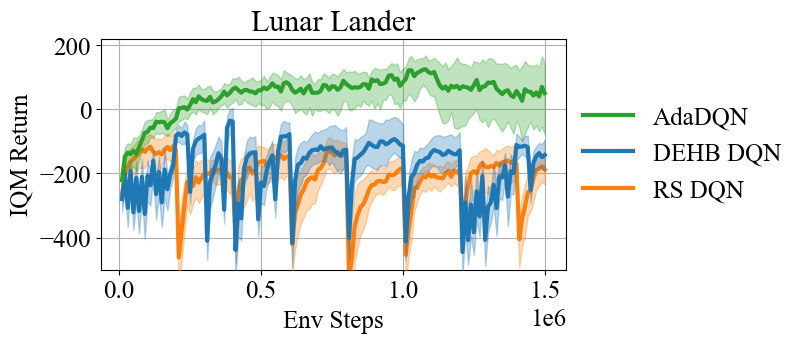

In [15]:
from experiments import DISPLAY_NAME, COLORS, ORDERS


plt.rc("font", family="serif", serif="Times New Roman", size=18)
plt.rc("lines", linewidth=3)

fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)

for experiment in experiment_folders:
	ax.plot(
		experiment_data[experiment]["x_values"][:150],
		experiment_data[experiment]["iqm"][:150],
		label=DISPLAY_NAME[experiment.split("/")[1]],
		color=COLORS[experiment.split("/")[1]],
		zorder=ORDERS[experiment.split("/")[1]]
	)
	ax.fill_between(
		experiment_data[experiment]["x_values"][:150],
		experiment_data[experiment]["confidence"][0][:150],
		experiment_data[experiment]["confidence"][1][:150],
		color=COLORS[experiment.split("/")[1]],
		alpha=0.3,
		zorder=ORDERS[experiment.split("/")[1]]
	)
	ax.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))

ax.set_xlabel("Env Steps")
ax.set_ylabel("IQM Return")
ax.set_ylim(-500, 220)
ax.set_yticks(np.arange(-400, 300, 200))

ax.grid()
ax.legend(ncols=1, frameon=False, loc="center", bbox_to_anchor=(1.25, 0.5))
ax.set_title("Lunar Lander")
fig.savefig(f"exp_output/non_static.pdf", bbox_inches='tight')